<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 2 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch import Tensor

from einops.layers.torch import Rearrange

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

from torch.optim import AdamW

import json

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tqdm
from PIL import Image

import wandb
import os

from torch.amp import GradScaler, autocast

In [2]:
print(torch.cuda.is_available())

True


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  WANDB </h2>
</div>

In [3]:
print(os.getcwd())

/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2


In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Assignment_2__2697258.ipynb" 

In [5]:
run  =  wandb.init(project="DI_725_Assignment_2___2697258", entity="DI_725_Assignment_2___2697258") 

wandb: Currently logged in as: turgay-yildiz-phi-e-pi (DI_725_Assignment_2___2697258). Use `wandb login --relogin` to force relogin


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Import Dataset  </h2>
</div>

In [6]:
path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/"

In [7]:
images_p        =    os.listdir(path + "auair2019/images")
annotations_p   =   path + "auair2019/annotations.json"

In [8]:
images_p[:3]

['frame_20190905103112_xx_0000365.jpg',
 'frame_20190906150731_xx_0002188.jpg',
 'frame_20190906150731_x_0001674.jpg']

In [9]:
with open(annotations_p, 'r') as f:
    annotations = json.load(f)

In [10]:
annotations_info    =   annotations["info"]
annotations_ann     =   annotations["annotations"]

In [11]:
annotations_info

{'description': 'AUAIR 2019 Dataset',
 'url': 'https://bozcani.github.io/AU-AIR-dataset.html',
 'version': '1.0',
 'year': '2019',
 'contributor': 'Ilker Bozcan',
 'date_created': '2019/10/01'}

In [12]:
len(annotations_ann)

32823

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  BBoxes </h2>
</div>

In [13]:
annotations_ann[1]["bbox"]

[{'top': 857, 'left': 976, 'height': 86, 'width': 139, 'class': 0},
 {'top': 11, 'left': 624, 'height': 210, 'width': 328, 'class': 1}]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Average Length of Classes for an image </h2>
</div>

In [14]:
summ = 0

for i in range(len(annotations_ann)):

    summ   +=    len(annotations_ann[i]["bbox"])

In [15]:
summ

132031

In [16]:
summ /  len(annotations_ann) 

4.0225147000578865

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Max Class Indices in an image</h2>
</div>

In [17]:
summs   =  [] 

for i in range(len(annotations_ann)):

    summs.append(len(annotations_ann[i]["bbox"]))

In [18]:
np.array(summs).max()

56

In [19]:
np.array(summs).argmax()

25251

In [20]:
annotations_ann[25251]["bbox"]

[{'top': 396, 'left': 439, 'height': 35, 'width': 101, 'class': 1},
 {'top': 375, 'left': 453, 'height': 30, 'width': 105, 'class': 1},
 {'top': 347, 'left': 464, 'height': 31, 'width': 83, 'class': 1},
 {'top': 328, 'left': 473, 'height': 27, 'width': 68, 'class': 1},
 {'top': 303, 'left': 468, 'height': 24, 'width': 85, 'class': 1},
 {'top': 293, 'left': 470, 'height': 18, 'width': 82, 'class': 1},
 {'top': 273, 'left': 477, 'height': 21, 'width': 68, 'class': 1},
 {'top': 260, 'left': 477, 'height': 18, 'width': 73, 'class': 1},
 {'top': 241, 'left': 481, 'height': 24, 'width': 63, 'class': 1},
 {'top': 236, 'left': 399, 'height': 27, 'width': 62, 'class': 1},
 {'top': 260, 'left': 400, 'height': 23, 'width': 63, 'class': 1},
 {'top': 276, 'left': 400, 'height': 20, 'width': 57, 'class': 1},
 {'top': 295, 'left': 404, 'height': 21, 'width': 49, 'class': 1},
 {'top': 312, 'left': 411, 'height': 27, 'width': 40, 'class': 1},
 {'top': 339, 'left': 418, 'height': 20, 'width': 33, 'class

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Unique Classes</h2>
</div>

In [21]:
lst   =   []

for i in range(len(annotations_ann)):

    bbox   =   annotations_ann[i]["bbox"]

    for j in range(len(bbox)):

        label   =   bbox[j]["class"] 

        if label  not  in  lst :
    
            lst.append(label) 


In [22]:
lst

[1, 0, 2, 3, 5, 7, 4, 6]

In [23]:
len(lst)

8

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Preprocess Data</h2>
</div>

In [12]:
def preprocess_annotations(annotations_ann):

    all_bboxes = []
    all_images = [] 

    path   =   "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/auair2019/images/"

    for i in tqdm.tqdm(range(len(annotations_ann))):

        
        image_name    =     annotations_ann[i]["image_name"] 
        img_path      =     os.path.join(path ,  image_name)   


        all_images.append(img_path)


        
        len_bbox   =  len(annotations_ann[i]["bbox"])
        bbox_list  =  []

        for j in range(len_bbox):

            top       =   annotations_ann[i]["bbox"][j]["top"]
            left      =   annotations_ann[i]["bbox"][j]["left"]
            height    =   annotations_ann[i]["bbox"][j]["height"]
            width     =   annotations_ann[i]["bbox"][j]["width"]
            clas      =   annotations_ann[i]["bbox"][j]["class"]

            bbox_list.append([top, left, height, width, clas])

        bbox_arr   =   np.array(bbox_list, dtype=np.float32)

        if  len_bbox  <  100:

            pad       =   np.zeros((100 - len_bbox, 5), dtype=np.float32)
            pad[:, 4] =   8      # padding class as 8 ("no object")
            bbox_arr  =   np.concatenate([bbox_arr, pad], axis=0)

        elif len_bbox  >  100:

            bbox_arr  =   bbox_arr[:100]

        all_bboxes.append(bbox_arr) 
    

    all_bboxes = np.stack(all_bboxes, axis=0)
    all_images = np.stack(all_images, axis=0)

    return    all_images,    all_bboxes


In [ ]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

In [ ]:
all_images.shape,  all_bboxes.shape

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check the Preprocessed Data</h2>
</div>

In [ ]:
all_images[0]

In [ ]:
all_bboxes[0][0]

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Original Dimensions </h2>
</div>

In [ ]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

In [ ]:
num  =  4

In [ ]:
img   =   Image.open(all_images[num]).convert("RGB")

In [ ]:
image = transforms.ToTensor()(img)

In [ ]:
image.shape

In [ ]:
all_bboxes[num][0]

In [ ]:
fig, ax = plt.subplots(1)


ax.imshow(img)

for i in range(100):
    
    rect = patches.Rectangle((all_bboxes[num][i][1], all_bboxes[num][i][0]), all_bboxes[num][i][3], all_bboxes[num][i][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Small Dimensions</h2>
</div>

In [ ]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

In [ ]:
num  =  1

In [ ]:
img     =   Image.open(all_images[num]).convert("RGB")

In [ ]:
t       =    transforms.Resize((480, 640))

In [ ]:
img2    =   t(img) 

In [ ]:
first   =  1080 / 480

In [ ]:
second  =  1920 / 640

In [ ]:
all_images,     all_bboxes    =    preprocess_annotations(annotations_ann)

In [ ]:
all_bboxes[:,  :,  0]   =  all_bboxes[:,  :,  0] / first
all_bboxes[:,  :,  2]   =  all_bboxes[:,  :,  2] / first

all_bboxes[:,  :,  1]   =  all_bboxes[:,  :,  1] / second
all_bboxes[:,  :,  3]   =  all_bboxes[:,  :,  3] / second

In [ ]:
fig, ax = plt.subplots(1)


ax.imshow(img2)

for i in range(100):
    
    rect = patches.Rectangle((all_bboxes[num][i][1], all_bboxes[num][i][0]), all_bboxes[num][i][3], all_bboxes[num][i][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Split Dataset according to the Report Paper </h2>
</div>

```python
annotations_train_val        =    all_bboxes[:30000,    :,  :]
annotations_test             =    all_bboxes[30000:-1,  :,  :] 
```

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Prepare Dataset for Training </h2>
</div>

In [19]:
class AUAIRDataset(Dataset):

    def __init__(self,  test = False,  transform=None):

        
        self.transform          =   transform 
        first                   =   1080 / 480
        second                  =   1920 / 640

        all_images,     all_bboxes    =    preprocess_annotations(annotations_ann) 

        all_bboxes[:,  :,  0]   =  all_bboxes[:,  :,  0] / first
        all_bboxes[:,  :,  2]   =  all_bboxes[:,  :,  2] / first 
        
        all_bboxes[:,  :,  1]   =  all_bboxes[:,  :,  1] / second
        all_bboxes[:,  :,  3]   =  all_bboxes[:,  :,  3] / second
        
        if test:

            self.annotations    =   all_bboxes[30000:-1,  :,  :]  
            self.img_paths      =   all_images[30000:-1] 

        else:

            self.annotations    =   all_bboxes[:30000,    :,  :]
            self.img_paths      =   all_images[:30000]  

    
    def __len__(self):
        
        return    5000 # len(self.annotations)  


    def __getitem__(self, idx):

        data          =     self.annotations[idx]   
        img_path      =     self.img_paths[idx]  
            
        image         =     Image.open(img_path).convert("RGB")   

                    
        
        if self.transform:
            
            image = self.transform(image) 
            

        image         =     np.array(image, dtype=np.float32)

        
        return     image,       data  



In [20]:
img_size   =   (480, 640) 

In [21]:
data_transform = transforms.Compose([
    
    transforms.Resize(img_size),  

])


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Training   </h2>
</div>

In [22]:
dataset      =   AUAIRDataset(    test=False,    transform  =  data_transform) 

100%|██████████| 32823/32823 [00:00<00:00, 130722.52it/s]


In [23]:
len(dataset)

5000

In [24]:
train_size   =    int(0.9 * len(dataset))
val_size     =    len(dataset) - train_size 

In [25]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

In [26]:
train_loader   =   DataLoader(train_dataset, batch_size=16, num_workers  =   8,   pin_memory = True,    shuffle=True)
val_loader     =   DataLoader(val_dataset,   batch_size=16, num_workers  =   8,   pin_memory = True,    shuffle=True)   

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Testing (Unseen Data)   </h2>
</div>

In [ ]:
#dataset2       =   AUAIRDataset(all_images,  all_bboxes,      test=True,    transform  =  data_transform)

In [ ]:
#len(dataset2)

In [ ]:
#test_loader   =   DataLoader(dataset2,  batch_size=16, num_workers  =   8,   pin_memory = True,   shuffle=True)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dimensions  </h2>
</div>

In [61]:
for imgs, bboxes in train_loader:
    break

In [62]:
imgs.shape

torch.Size([16, 480, 640, 3])

In [63]:
bboxes.shape

torch.Size([16, 100, 5])

In [64]:
num  =  0

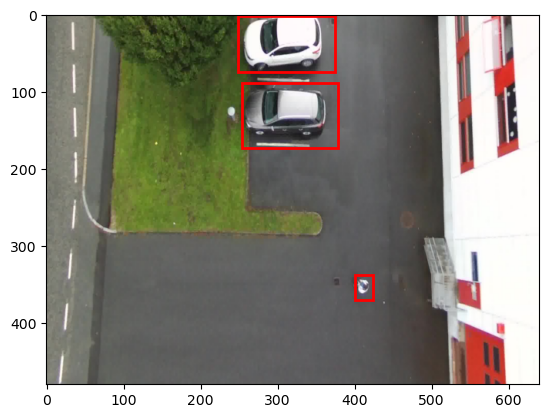

In [65]:
fig, ax = plt.subplots(1)


ax.imshow(imgs[num]/255.0)

for k in range(100):
    
    rect = patches.Rectangle((bboxes[num][k][1], bboxes[num][k][0]), bboxes[num][k][3], bboxes[num][k][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Custom Loss   </h2>
</div>

In [27]:
def create_bbox_images(images, bboxes, preds):         #  b x 3 x 480 x 640             #  b x 100 x 4
    
    imgs_org                      =   imgs.cpu().numpy() 
    batch_size, H, W, channels    =   imgs_org.shape
    output_org                    =   np.zeros((batch_size, H, W, channels)) 
    output_pred                   =   np.zeros((batch_size, H, W, channels)) 
    
    for i in range(batch_size):
        
        for j in range(100):
        
            if bboxes[i][j].sum()  == 0:
                
                break 
#--------------------------------------------------------------------------------------------------------------#
        
        for k in range(j):
            
            top_org              =   int(round(bboxes[i][k][0].item()))
            left_org             =   int(round(bboxes[i][k][1].item()))
            height_org           =   int(round(bboxes[i][k][2].item()))
            width_org            =   int(round(bboxes[i][k][3].item()))
    
            
            if top_org  < 0:
                top_org                =   0
            if left_org  < 0:
                left_org               =   0
            if top_org  + height_org  > H:
                height_org             =   H - top_org
            if left_org  + width_org  > W:
                width_org              =   W - left_org 
    
            
            output_org[i, top_org:top_org+height_org, left_org:left_org+width_org, :]    =   imgs_org[i, top_org:top_org+height_org, left_org:left_org+width_org, :]
     
#--------------------------------------------------------------------------------------------------------------#
                    
            top                   =   int(round(preds[i][k][0].item()))
            left                  =   int(round(preds[i][k][1].item()))
            height                =   int(round(preds[i][k][2].item()))
            width                 =   int(round(preds[i][k][3].item())) 
        
            if top < 0:
                top               =   0
            if left < 0:
                left              =   0
            if top + height > H:
                height            =   H - top
            if left + width > W:
                width             =   W - left
        
            output_pred[i, top:top+height, left:left+width, :]    =   imgs_org[i, top:top+height, left:left+width, :] 

#--------------------------------------------------------------------------------------------------------------#  
    
    return torch.tensor(output_org),   torch.tensor(output_pred) 


In [94]:
out_org,  out_pred   =   create_bbox_images(imgs, bboxes, bboxes ) 

In [95]:
out_org.shape

torch.Size([16, 480, 640, 3])

In [96]:
num  =  0

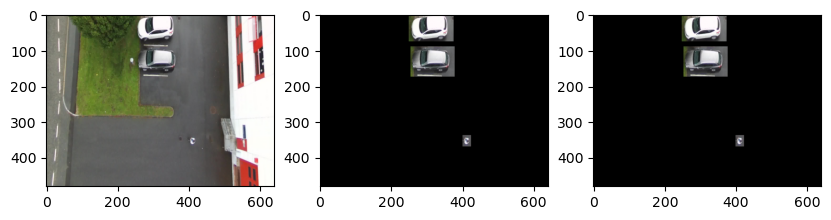

In [97]:
fig, ax    =   plt.subplots(1,3, figsize=(10,12))


ax[0].imshow(imgs[num]/255.0)
ax[1].imshow(out_org[num]/255.0 )
ax[2].imshow(out_pred[num]/255.0 ) 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:10px;">
<h2>  Model </h2>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Patch Embeddings </h2>
</div>


In [ ]:
def extract_non_overlapping_patches(images, patch_size):
    
    batch_size, channels, height, width    =   images.shape
    num_patches_h                          =   height // patch_size  
    num_patches_w                          =   width // patch_size  
    num_patches                            =   num_patches_h * num_patches_w  

    # Initialize a list to store patches
    patches                              =   []

    for img in images:
        
        img_patches                    =   []
            
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                # Extract a patch with all channels
                patch            =   img[:, i * patch_size : (i + 1) * patch_size, j * patch_size : (j + 1) * patch_size]
                # Add the patch to the list
                img_patches.append(patch)
         
        patches.append(torch.stack(img_patches))

    patches                              =   torch.stack(patches)

    return patches.reshape(batch_size, num_patches, channels * (patch_size ** 2))


In [ ]:
if 1:
    dummy   =   torch.zeros(8, 3, 480, 640)
    out     =   extract_non_overlapping_patches(dummy, 32)
    
    print(out.shape)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  CNN  </h2>
</div>


In [28]:
class CNN(nn.Module):
    def __init__(self, num_words=0,   embed_dim=0):

        super(CNN, self).__init__()

        self.num_words  =  num_words
        self.embed_dim  =  embed_dim 
        
#--------------------------------------------------------------------------------------------------------------------#

        self.encoder = nn.Sequential(
    
                nn.Conv2d(3, 6, kernel_size=3, padding=1),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),  
                
                nn.Conv2d(6, 9, kernel_size=3, padding=1),
                nn.BatchNorm2d(9),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2), 
            
                nn.Conv2d(9, 12, kernel_size=3, padding=1),
                nn.BatchNorm2d(12), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),  

            )

#--------------------------------------------------------------------------------------------------------------------#
        self.flatten    = nn.Flatten()
#--------------------------------------------------------------------------------------------------------------------#        
        self.apply(self.init_weights)
#--------------------------------------------------------------------------------------------------------------------#    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights for Linear and Conv2d/ConvTranspose2d layers using Kaiming initialization.
        """
        if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
#--------------------------------------------------------------------------------------------------------------------#    
    def forward(self, x):

        x_enc  = self.encoder(x)           
        x_flat = self.flatten(x_enc)       
          
        
        return  x_flat.view(-1, self.num_words , self.embed_dim)


In [29]:
if 0:
    dummy   =   torch.zeros(8, 3, 480, 640)
    e       =   CNN(100, 48 * 32) 
    #print(e.encoder(dummy).shape)
    print(e.forward(dummy).shape)

    num_params = sum(p.numel() for p in e.parameters() if p.requires_grad)

    print("Number of trainable parameters in the model:", num_params)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Embeddings </h2>
</div>


In [30]:
class Embeddings(nn.Module):
    
    def __init__(self, num_words, embed_dim):
        
        super().__init__()

        self.num_words            =   num_words
        self.embed_dim            =   embed_dim

        self.encoder              =   CNN( num_words=num_words,   embed_dim=embed_dim)

        self.position_embeddings  =   nn.Embedding(self.num_words,  self.embed_dim)    
        self.layer_norm           =   nn.LayerNorm(self.embed_dim, eps=1e-12)              
    
    def forward(self, x):   
        
        position_ids         =  torch.arange(self.num_words, device=x.device).unsqueeze(0) 
        position_embeddings  =  self.position_embeddings(position_ids)

        
        #patches             =  extract_non_overlapping_patches(x, 32) 
        patches              =  self.encoder(x) 

        
        # Combine token and position embeddings
        
        embeddings = patches + position_embeddings
        embeddings = self.layer_norm(embeddings)
        
        return embeddings 

In [31]:
if 0:
    dummy   =   torch.zeros(8, 3, 480, 640)
    e       =   Embeddings(128, 256)
    print(e.forward(dummy).shape)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Scaled Dot Product </h2>
</div>


In [32]:
def scaled_dot_product_attention(query, key, value):
    
    dim_k   =  query.size(-1)
    scores  =  torch.bmm(query, key.transpose(1, 2)) / np.sqrt(dim_k)
    weights =  F.softmax(scores, dim=-1)
    
    return torch.bmm(weights, value)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Attention Head</h2>
</div>


In [33]:
class AttentionHead(nn.Module):
    
    def __init__(self, dim_word, head_dim):
        
        super().__init__()

        self.dim_word  = dim_word
        self.head_dim  = head_dim 
        
        self.q = nn.Linear(self.dim_word, self.head_dim)     
        self.k = nn.Linear(self.dim_word, self.head_dim)
        self.v = nn.Linear(self.dim_word, self.head_dim)  
        
    
    def forward(self, x):  
     
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        
        attn_outputs = scaled_dot_product_attention(q, k, v)
        
        return attn_outputs


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Multi-Head Attention </h2>
</div>


In [34]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, embed_dim, num_heads):
        
        super().__init__()
        
        self.num_heads = num_heads
        self.head_dim  = embed_dim // num_heads
        self.heads     = nn.ModuleList([AttentionHead(embed_dim, self.head_dim) for _ in range(num_heads)])
        
        self.output_linear  = nn.Linear(embed_dim, embed_dim)
        self.norm1          = nn.LayerNorm(embed_dim) 
        self.gelu1          = nn.GELU()
    
    def forward(self, hidden_state):
    
        head_outputs = [h(hidden_state) for h in self.heads]
        
        x = torch.cat(head_outputs, dim=-1)
        
        x = self.gelu1(self.norm1(self.output_linear(x)))   
        
        return x


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  FeedForward </h2>
</div>


In [35]:
class FeedForward(nn.Module):
    
    def __init__(self, embed_dim):
        
        super(FeedForward, self).__init__()

        self.embed_dim = embed_dim 
        
        self.linear_1       =  nn.Linear(self.embed_dim, self.embed_dim * 4)   
        self.norm1          =  nn.LayerNorm(self.embed_dim * 4) 
        self.gelu1          =  nn.GELU()
        
        self.linear_2       =  nn.Linear(self.embed_dim * 4, self.embed_dim) 
        self.norm2          =  nn.LayerNorm(self.embed_dim) 
        self.gelu2          =  nn.GELU()
        
        self.dropout  = nn.Dropout(0.2)

    def forward(self, x):
        

        batch_size, seq_len, _ = x.size()
        
        x = x.view(batch_size * seq_len, -1)  
        
        x = self.gelu1(self.norm1(self.linear_1(x)))
        x = self.gelu2(self.norm2(self.linear_2(x)))
        
        x = self.dropout(x)
        
        x = x.view(batch_size, seq_len, -1)  
        
        return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Transformer Encoder Layer</h2>
</div>


In [36]:
class TransformerEncoderLayer(nn.Module):
    
    def __init__(self, embed_dim, num_heads):
        
        super().__init__()

        self.embed_dim  = embed_dim
        self.num_heads  = num_heads
        
        self.layer_norm_1  =  nn.LayerNorm(embed_dim)
        self.layer_norm_2  =  nn.LayerNorm(embed_dim)
        self.layer_norm_3  =  nn.LayerNorm(embed_dim)
        
        self.attention     =  MultiHeadAttention(embed_dim, num_heads)       
        self.feed_forward  =  FeedForward(embed_dim)
        
    def forward(self, x):
        
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))

        x = self.layer_norm_3(x) 
        
        return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Transformer Encoder </h2>
</div>


In [37]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, num_words=0, embed_dim=0, num_heads=0, n_layer=0):     
        
        super().__init__()

        if (embed_dim % num_heads) != 0:
            print("Embed dimension must be divisible by num_head!")
            
        self.num_words            =  num_words
        self.embed_dim            =  embed_dim
        self.num_heads            =  num_heads

        self.embeddings = Embeddings(self.num_words, self.embed_dim) 
        self.layers     = nn.ModuleList([TransformerEncoderLayer(self.embed_dim, self.num_heads) for _ in range(n_layer)])
            
    def forward(self, x):
        
        x = self.embeddings(x)   
        
        for layer in self.layers:
            x = layer(x)
        
        return x 

In [38]:
if 0:
    dummy   =   torch.zeros(8, 3, 480, 640)
    e       =   TransformerEncoder(100, 576, 8, 6)
    print(e.forward(dummy).shape)

    num_params = sum(p.numel() for p in e.parameters() if p.requires_grad)

    print("Number of trainable parameters in the model:", num_params)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  ResNET as Backbone </h2>
</div>

In [34]:
if 0:

    import torchvision.models as models
    
    class ResNetBackbone(nn.Module):
        
        def __init__(self, embed_dim):
            super().__init__()
            self.resnet       =   models.resnet50(weights=True)
            self.resnet       =   nn.Sequential(*list(self.resnet.children())[:-2])
            self.projection   =   nn.Linear(2048, embed_dim)
            
        def forward(self, x: Tensor) -> Tensor:
            x                =   self.resnet(x)                      # B x 2048 x H' x W'
            B, C, H, W       =   x.shape
            x                =   x.view(B, C, H * W).permute(0, 2, 1)  # B x (H'*W') x 2048
            x                =   self.projection(x)                  # B x (H'*W') x embed_dim
            return x

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  ViT </h2>
</div>

In [39]:
class ViT(nn.Module):
    
    def __init__(self,   num_words = 0, embed_dim = 0, num_heads = 0, n_layer = 0):
        
        super(ViT, self).__init__()

        self.embed_dim     =   embed_dim 
#---------------------------------------------------------------------------------------------------------------------------------------#
        
        self.encoder       =   TransformerEncoder(num_words,  embed_dim,  num_heads, n_layer)    #  input=aoutput=    batch   x   num_words   x   embed_dim      
        
        self.classifier1   =   nn.Linear(2 * embed_dim ,   900)  
        
        self.classifier2   =   nn.Linear(2 * embed_dim ,   400)
        
#---------------------------------------------------------------------------------------------------------------------------------------#
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear): 
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
#---------------------------------------------------------------------------------------------------------------------------------------#
    
    def forward(self, x):  
        
        x   =   self.encoder(x)[:, :2,  :].view(-1,   2*self.embed_dim )                           
        
        clas = self.classifier1(x).sigmoid() 
        
        bbox = self.classifier2(x)
        
        return    bbox.view(-1, 100, 4) ,    clas.view(-1, 100, 9) 


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Checking the Dimensions </h2>
</div>

In [ ]:
if 0:
    m       =   ViT( num_words = 128, embed_dim = 768, num_heads=6 , n_layer=6) 

    dummy   =   torch.zeros(8, 3, 480, 640)

    x       =   m.forward(dummy)  

In [ ]:
if 0:
    dummy   =   torch.zeros(8, 3, 480, 640)

In [ ]:
if 0:
    x       =  m.forward(dummy)  

In [ ]:
if 0:
    print(x[0].shape),  print(x[1].shape)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check Number of  Parameters :</h2>
</div>

In [ ]:
model   =  ViT( num_words = 100, embed_dim = 576, num_heads=8 , n_layer=6)

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Employ GPU</h2>
</div>

In [40]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
device

device(type='cuda')

In [42]:
model   =  ViT( num_words = 100, embed_dim = 576, num_heads=8 , n_layer=6).to(device)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  To Save Weights and Losses : </h2>
</div>

In [43]:
path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_weight_1.pth"
path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_losses_1.pth"

In [44]:
if False:
    
    torch.save({
            'model_state_dict': model.state_dict(),
            'best_loss'       : 9999999999999,
        }, path_model)   

In [45]:
if False:
    
    torch.save({
        
            'train_loss'    : [],
            'val_loss'      : [], 
    
            'epochs'        : [],
    
        }, path_losses)    

In [46]:
if 1:
    
    checkpoint_weights   =   torch.load(path_model, weights_only=True) 
    checkpoint_losses    =   torch.load(path_losses, weights_only=True)  
    
    model.load_state_dict(checkpoint_weights['model_state_dict'])
    
    best_loss       =  checkpoint_weights['best_loss'] 
    train_loss      =  checkpoint_losses['train_loss']
    val_loss        =  checkpoint_losses['val_loss']
    
    epochs          =  checkpoint_losses['epochs'] 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Loss Functions : </h2>
</div>

In [47]:
import math

In [109]:
def giou_loss(pred_boxes, target_boxes):
    # pred_boxes and target_boxes are assumed to be [N,4] in (x1, y1, x2, y2) format
    x1_pred   = pred_boxes[:, 0]
    y1_pred   = pred_boxes[:, 1]
    x2_pred   = pred_boxes[:, 2]
    y2_pred   = pred_boxes[:, 3]
    
    x1_target = target_boxes[:, 0]
    y1_target = target_boxes[:, 1]
    x2_target = target_boxes[:, 2]
    y2_target = target_boxes[:, 3]
    
    # Intersection coordinates
    x1_int = torch.max(x1_pred, x1_target)
    y1_int = torch.max(y1_pred, y1_target)
    x2_int = torch.min(x2_pred, x2_target)
    y2_int = torch.min(y2_pred, y2_target)
    
    inter_area = (x2_int - x1_int).clamp(min=0) * (y2_int - y1_int).clamp(min=0)
    
    # Areas of prediction and target
    area_pred   = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    area_target = (x2_target - x1_target) * (y2_target - y1_target)
    
    union_area  = area_pred + area_target - inter_area + 1e-7
    iou         = inter_area / union_area
    
    # Enclosing box
    x1_enc = torch.min(x1_pred, x1_target)
    y1_enc = torch.min(y1_pred, y1_target)
    x2_enc = torch.max(x2_pred, x2_target)
    y2_enc = torch.max(y2_pred, y2_target)
    enc_area = (x2_enc - x1_enc) * (y2_enc - y1_enc) + 1e-7

    giou = iou - ((enc_area - union_area) / enc_area)
    loss = 1 - giou
    return loss.mean()

In [48]:
def ciou_loss(pred_boxes, target_boxes, eps=1e-7):
    
    x1_p   = pred_boxes[:, 0]
    y1_p   = pred_boxes[:, 1]
    x2_p   = pred_boxes[:, 2]
    y2_p   = pred_boxes[:, 3]
    
    x1_t   = target_boxes[:, 0]
    y1_t   = target_boxes[:, 1]
    x2_t   = target_boxes[:, 2]
    y2_t   = target_boxes[:, 3]
    
    w_p    = (x2_p - x1_p).clamp(min=eps)
    h_p    = (y2_p - y1_p).clamp(min=eps)
    cx_p   = (x1_p + x2_p) / 2
    cy_p   = (y1_p + y2_p) / 2
    
    w_t    = (x2_t - x1_t).clamp(min=eps)
    h_t    = (y2_t - y1_t).clamp(min=eps)
    cx_t   = (x1_t + x2_t) / 2
    cy_t   = (y1_t + y2_t) / 2
    
    inter_x1   = torch.max(x1_p, x1_t)
    inter_y1   = torch.max(y1_p, y1_t)
    inter_x2   = torch.min(x2_p, x2_t)
    inter_y2   = torch.min(y2_p, y2_t)
    inter_w    = (inter_x2 - inter_x1).clamp(min=0)
    inter_h    = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h
    
    area_p   = w_p * h_p
    area_t   = w_t * h_t
    union    = area_p + area_t - inter_area + eps
    iou      = inter_area / union
    
    center_distance = (cx_p - cx_t)**2 + (cy_p - cy_t)**2
    
    enc_x1   = torch.min(x1_p, x1_t)
    enc_y1   = torch.min(y1_p, y1_t)
    enc_x2   = torch.max(x2_p, x2_t)
    enc_y2   = torch.max(y2_p, y2_t)
    enc_w    = (enc_x2 - enc_x1).clamp(min=eps)
    enc_h    = (enc_y2 - enc_y1).clamp(min=eps)
    c2       = enc_w**2 + enc_h**2
    
    atan_p   = torch.atan(w_p / (h_p + eps))
    atan_t   = torch.atan(w_t / (h_t + eps))
    v        = (4 / (math.pi ** 2)) * (atan_t - atan_p)**2
    
    with torch.no_grad():
        alpha  = v / (1 - iou + v + eps)
    
    ciou_val = iou - (center_distance / (c2 + eps)) - alpha * v
    loss     = 1 - ciou_val
    return loss.mean()

def ciou_loss_batch(pred, target, eps=1e-7):
    # pred and target are [B, 100, 5] in (top, left, height, width, class)
    B, N, _  = pred.shape
    pred_xyxy    = torch.zeros((B, N, 4), device=pred.device)
    target_xyxy  = torch.zeros((B, N, 4), device=target.device)
    
    # Convert (top, left, height, width) to (x1, y1, x2, y2)
    pred_xyxy[:,:,0] = pred[:,:,1]
    pred_xyxy[:,:,1] = pred[:,:,0]
    pred_xyxy[:,:,2] = pred[:,:,1] + pred[:,:,3]
    pred_xyxy[:,:,3] = pred[:,:,0] + pred[:,:,2]
    
    target_xyxy[:,:,0] = target[:,:,1]
    target_xyxy[:,:,1] = target[:,:,0]
    target_xyxy[:,:,2] = target[:,:,1] + target[:,:,3]
    target_xyxy[:,:,3] = target[:,:,0] + target[:,:,2]
    
    pred_xyxy    = pred_xyxy.view(-1, 4)
    target_xyxy  = target_xyxy.view(-1, 4)
    
    return ciou_loss(pred_xyxy, target_xyxy, eps)

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Training : </h2>
</div>

In [49]:
def train(num_epochs=0, patience=0, counter=0, learning_rate=0, best_loss=best_loss):
    
    optimizer       =   AdamW(model.parameters(), lr=learning_rate)
    criterion       =   nn.BCEWithLogitsLoss() 
    
    run.log({"LRate": learning_rate})  
    
    scheduler       =   torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5) 
    scaler          =   GradScaler()

    for epoch in range(num_epochs):
    
        model.train()
        
        total_loss_train   =   0
        
        for img, bbox in tqdm.tqdm(train_loader):
            
            img       =     img.to(device)
            bbox      =     bbox.to(device) 

            run.log({"Batch_size": img.shape[0]})   
    
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                
                bbox_preds, class_preds   =   model(img.view(-1, 3, 480, 640))
                bbox_preds                =   bbox_preds.squeeze() 
                class_preds               =   class_preds.squeeze()
                gt_bbox                   =   bbox[:, :, :4]
                gt_class                  =   bbox[:, :, 4].long() 
                
                gt_class_one_hot          =   F.one_hot(gt_class, num_classes=9).float()

                #out_org,  out_pred        =   create_bbox_images(img, gt_bbox, bbox_preds ) 
                #out_org                   =   out_org.to(device)
                #out_pred                  =   out_pred.to(device) 

                
                loss_imgs   =   0  #F.mse_loss(out_org, out_pred) 
                #loss_bb    =   F.mse_loss(bbox_preds  , gt_bbox)  
                loss_bb     =   ciou_loss_batch(bbox_preds, gt_bbox, eps=1e-7)  #  giou_loss(bbox_preds, gt_bbox)
                loss_cl     =   criterion(class_preds , gt_class_one_hot )  
       

                loss   =  loss_imgs +  loss_bb + loss_cl
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            total_loss_train   +=   loss.item()

        total_loss_train   /=   len(train_loader)

        train_loss.append(total_loss_train)
    
        run.log({"Train Loss": total_loss_train})
    
        if torch.isnan(torch.tensor(total_loss_train)):
            print("NaN value encountered!")
            break

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss : {total_loss_train:.4f}           |")
        print("-------------------------------------------------------------------------------")

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss IMGS : {loss_imgs:.4f}           |")
        print("-------------------------------------------------------------------------------")
        
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss BBOX : {loss_bb:.4f}           |")
        print("-------------------------------------------------------------------------------")

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train Loss  CLS: {loss_cl:.4f}           |")
        print("-------------------------------------------------------------------------------")

#-----------------------------------------------------------------------------------------------
        
        model.eval()

        total_loss_val   =   0.0

        with torch.no_grad():
            
            for img, bbox in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

                img       =     img.to(device)
                bbox      =     bbox.to(device) 
            
                with autocast(device_type='cuda'):
                    
                    bbox_preds, class_preds   =   model(img.view(-1, 3, 480, 640))
                    bbox_preds                =   bbox_preds.squeeze() 
                    class_preds               =   class_preds.squeeze()
                    gt_bbox                   =   bbox[:, :, :4]
                    gt_class                  =   bbox[:, :, 4].long() 
                    
                    gt_class_one_hot          =   F.one_hot(gt_class, num_classes=9).float()

                    #out_org,  out_pred        =   create_bbox_images(img, gt_bbox, bbox_preds ) 
                    #out_org                   =   out_org.to(device)
                    #out_pred                  =   out_pred.to(device) 
    
                    
                    loss_imgs   =   0  #F.mse_loss(out_org, out_pred) 
                    #loss_bb    =   F.mse_loss(bbox_preds  , gt_bbox)  
                    loss_bb     =   ciou_loss_batch(bbox_preds, gt_bbox, eps=1e-7)  #  giou_loss(bbox_preds, gt_bbox)
                    loss_cl     =   criterion(class_preds , gt_class_one_hot )  
       

                    loss   =  loss_imgs +  loss_bb + loss_cl 
    
    
                total_loss_val   +=   loss.item()

        total_loss_val   /=   len(val_loader)

        val_loss.append(total_loss_val)

        run.log({"Val Loss": total_loss_val})

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation Loss : {total_loss_val:.4f}           |")
        print("-------------------------------------------------------------------------------")

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |       Total Validation Loss IMGS : {loss_imgs:.4f}           |")
        print("-------------------------------------------------------------------------------")
        
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |       Total Validation Loss BBOX : {loss_bb:.4f}           |")
        print("-------------------------------------------------------------------------------")

        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |       Total Validation Loss  CLS: {loss_cl:.4f}           |")
        print("-------------------------------------------------------------------------------")

        if len(val_loss) >= 2:
            res       =   ((val_loss[-2] - val_loss[-1]) / val_loss[-2]) * 100
            print("-------------------------------------------------------------------------------")
            print(f"|              Change in loss is      %   {res:.2f}                               |")
            print("-------------------------------------------------------------------------------")

        if total_loss_val < best_loss:
            
            print("*************...saving best model *************")
            
            best_loss       =   total_loss_val
            
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_loss'       : best_loss,
            }, path_model)
             

        epochs.append(epoch)

        torch.save({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs': epochs,
        }, path_losses)

        if (len(val_loss) >= 2) and (val_loss[-2] > val_loss[-1]):
            counter       =   0
        else:
            counter       +=   1
            if counter >= patience:
                print("Early stopping!")
                break

        scheduler.step()  
        torch.cuda.empty_cache()


In [50]:
torch.cuda.empty_cache()

In [52]:
train(num_epochs=3, patience=10, counter=0, learning_rate=0.0001, best_loss=best_loss)

100%|██████████| 282/282 [00:47<00:00,  5.93it/s]


-------------------------------------------------------------------------------
|  Epoch [1/3]          |        Total Train Loss : 1.6801           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/3]          |        Total Train Loss IMGS : 0.0000           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/3]          |        Total Train Loss BBOX : 1.0133           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/3]          |        Total Train Loss  CLS: 0.6525           |
-------------------------------------------------------------------------------


Epoch 1/3: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]


-------------------------------------------------------------------------------
|  Epoch [1/3]         |       Total Validation Loss : 1.6688           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/3]          |       Total Validation Loss IMGS : 0.0000           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/3]          |       Total Validation Loss BBOX : 1.0153           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/3]          |       Total Validation Loss  CLS: 0.6526           |
-------------------------------------------------------------------------------
-----------------------------------------------

100%|██████████| 282/282 [00:47<00:00,  5.90it/s]


-------------------------------------------------------------------------------
|  Epoch [2/3]          |        Total Train Loss : 1.6673           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/3]          |        Total Train Loss IMGS : 0.0000           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/3]          |        Total Train Loss BBOX : 1.0104           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/3]          |        Total Train Loss  CLS: 0.6528           |
-------------------------------------------------------------------------------


Epoch 2/3: 100%|██████████| 32/32 [00:03<00:00,  8.32it/s]


-------------------------------------------------------------------------------
|  Epoch [2/3]         |       Total Validation Loss : 1.6658           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/3]          |       Total Validation Loss IMGS : 0.0000           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/3]          |       Total Validation Loss BBOX : 1.0165           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/3]          |       Total Validation Loss  CLS: 0.6536           |
-------------------------------------------------------------------------------
-----------------------------------------------

100%|██████████| 282/282 [00:47<00:00,  5.92it/s]


-------------------------------------------------------------------------------
|  Epoch [3/3]          |        Total Train Loss : 1.6647           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/3]          |        Total Train Loss IMGS : 0.0000           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/3]          |        Total Train Loss BBOX : 1.0078           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/3]          |        Total Train Loss  CLS: 0.6517           |
-------------------------------------------------------------------------------


Epoch 3/3: 100%|██████████| 32/32 [00:03<00:00,  8.81it/s]


-------------------------------------------------------------------------------
|  Epoch [3/3]         |       Total Validation Loss : 1.6635           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/3]          |       Total Validation Loss IMGS : 0.0000           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/3]          |       Total Validation Loss BBOX : 1.0093           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/3]          |       Total Validation Loss  CLS: 0.6523           |
-------------------------------------------------------------------------------
-----------------------------------------------

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Results : </h2>
</div>

In [53]:
e  =  model.eval()

In [54]:
for i, j in train_loader:
    break

In [55]:
i.shape

torch.Size([16, 480, 640, 3])

In [56]:
j.shape

torch.Size([16, 100, 5])

In [61]:
num  =  2

In [62]:
with torch.no_grad():

    img       =     (i[num]/255.0).to(device) 

    bbox_preds, class_preds   =   model(img.view(-1, 3, 480, 640))


In [63]:
class_preds.shape

torch.Size([1, 100, 9])

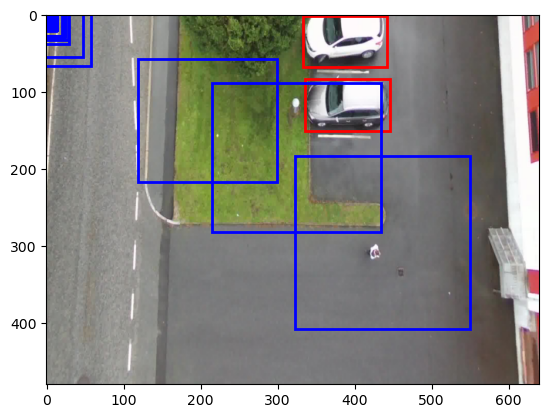

In [64]:
fig, ax = plt.subplots(1)


ax.imshow(i[num]/255.0)

for k in range(100):
    
    rect = patches.Rectangle((j[num][k][1], j[num][k][0]), j[num][k][3], j[num][k][2], linewidth=2, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)


for k in range(100):
    
    rect = patches.Rectangle((bbox_preds[0][k][1].cpu(), bbox_preds[0][k][0].cpu()), bbox_preds[0][k][3].cpu(), bbox_preds[0][k][2].cpu(), linewidth=2, edgecolor='b', facecolor='none')
    
    ax.add_patch(rect)

plt.show()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Evaluation Metrices</h2>
</div>

In [46]:
def compute_iou(box1, box2):
    # box1: [N, 4], box2: [M, 4] in format (top, left, height, width)
    box1_y1  = box1[:, 0]
    box1_x1  = box1[:, 1]
    box1_y2  = box1[:, 0] + box1[:, 2]
    box1_x2  = box1[:, 1] + box1[:, 3]

    box2_y1  = box2[:, 0]
    box2_x1  = box2[:, 1]
    box2_y2  = box2[:, 0] + box2[:, 2]
    box2_x2  = box2[:, 1] + box2[:, 3]

    y1 = torch.max(box1_y1.unsqueeze(1), box2_y1.unsqueeze(0))
    x1 = torch.max(box1_x1.unsqueeze(1), box2_x1.unsqueeze(0))
    y2 = torch.min(box1_y2.unsqueeze(1), box2_y2.unsqueeze(0))
    x2 = torch.min(box1_x2.unsqueeze(1), box2_x2.unsqueeze(0))
    
    inter_h = (y2 - y1).clamp(min=0)
    inter_w = (x2 - x1).clamp(min=0)
    inter_area = inter_h * inter_w

    area1 = box1[:, 2] * box1[:, 3]
    area2 = box2[:, 2] * box2[:, 3]
    union_area = area1.unsqueeze(1) + area2.unsqueeze(0) - inter_area

    iou = inter_area / (union_area + 1e-6)
    return iou

In [ ]:
def evaluate_image(pred_boxes, pred_scores, pred_classes, gt_boxes, gt_classes, iou_thresh=0.5):
    # pred_boxes: [N, 4], pred_scores: [N], pred_classes: [N]
    # gt_boxes: [M, 4], gt_classes: [M]
    N = pred_boxes.shape[0]
    M = gt_boxes.shape[0]
    if N == 0:
        return 0.0, 0.0, 0.0
    iou_matrix = compute_iou(pred_boxes, gt_boxes)
    matches = []
    for i in range(N):
        for j in range(M):
            if iou_matrix[i, j] >= iou_thresh and pred_classes[i] == gt_classes[j]:
                matches.append((pred_scores[i].item(), i, j, iou_matrix[i, j].item()))
    matches = sorted(matches, key=lambda x: x[0], reverse=True)
    used_gt = set()
    tp = 0
    for score, i, j, iou_val in matches:
        if j not in used_gt:
            tp += 1
            used_gt.add(j)
    fp = N - tp
    fn = M - len(used_gt)
    precision = tp / (tp + fp + 1e-6)
    recall    = tp / (tp + fn + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    return precision, recall, f1

In [ ]:
def compute_ap(precisions, recalls):
    # 11-point interpolated average precision
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        p = precisions[recalls >= t]
        if p.numel() > 0:
            p_max = p.max().item()
        else:
            p_max = 0.0
        ap += p_max
    ap = ap / 11.0
    return ap

In [ ]:
def evaluate_dataset(preds, gts, iou_thresh=0.5, num_classes=9):
    # preds: list of dict, each with keys: 'boxes': [N,4], 'scores': [N], 'classes': [N]
    # gts:   list of dict, each with keys: 'boxes': [M,4], 'classes': [M]
    aps = []
    for c in range(num_classes):
        all_precisions = []
        all_recalls    = []
        for pred, gt in zip(preds, gts):
            if pred['boxes'].numel() == 0 or gt['boxes'].numel() == 0:
                continue
            # Select class c predictions and ground truth
            idx_pred = (pred['classes'] == c).nonzero(as_tuple=True)[0]
            idx_gt   = (gt['classes'] == c).nonzero(as_tuple=True)[0]
            if idx_pred.numel() == 0 or idx_gt.numel() == 0:
                continue
            pred_boxes   = pred['boxes'][idx_pred]
            pred_scores  = pred['scores'][idx_pred]
            pred_cls     = pred['classes'][idx_pred]
            gt_boxes     = gt['boxes'][idx_gt]
            gt_cls       = gt['classes'][idx_gt]
            p, r, _      = evaluate_image(pred_boxes, pred_scores, pred_cls, gt_boxes, gt_cls, iou_thresh)
            all_precisions.append(p)
            all_recalls.append(r)
        if len(all_precisions) > 0:
            precisions = torch.tensor(all_precisions)
            recalls    = torch.tensor(all_recalls)
            ap = compute_ap(precisions, recalls)
        else:
            ap = 0.0
        aps.append(ap)
    mAP = np.mean(aps)
    return mAP, aps

In [ ]:
# Example usage:
# Suppose preds_list and gts_list are lists over the validation dataset, each element is a dict:
# preds_list[i] = {'boxes': tensor of shape [N,4], 'scores': tensor of shape [N], 'classes': tensor of shape [N]}
# gts_list[i]   = {'boxes': tensor of shape [M,4], 'classes': tensor of shape [M]}
# mAP, per_class_ap = evaluate_dataset(preds_list, gts_list, iou_thresh=0.5, num_classes=9)



<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [ ]:
#run.finish() 